# Calculating the Foldiness Score of the Neural Cortex

We compute the **foldiness score** of the cerebral cortex as a composite metric based on three quantitative measures:

- **Fractal Dimension** $D_f$
- **Gyrification Index** $GI$
- **Mean Curvature** $\bar{H}$

These metrics capture complementary aspects of cortical folding and surface complexity.

## Input Segmentation

All calculations are performed on the **gray matter** mask of the cortex. Initially this mask is obtained via **Otsu’s multithresholding method**, which segments the image into multiple intensity-based classes, isolating the cortical gray matter. I have manually labelled the **gray matter** for a sample cortex and trained a lightweight machine learning model to segment gray matter based on image intensity and distance from the center.

## Component Metrics

1. **Fractal Dimension**  
   The fractal dimension $D_f$ quantifies the self-similarity and complexity of the cortical surface. It is estimated using box-counting or similar fractal analysis methods:

   $$
   D_f = \lim_{\epsilon \to 0} \frac{\log N(\epsilon)}{\log(1/\epsilon)}
   $$

   where $N(\epsilon)$ is the number of boxes of side length $\epsilon$ needed to cover the cortical surface.

2. **Gyrification Index (GI)**  
   In this 2D formulation, the gyrification index is defined as the ratio of the length of the actual cortex contour to the length of its convex hull:

   $$
   GI = \frac{L_{\text{cortex}}}{L_{\text{convex}}}
   $$

   where:
   - $L_{\text{cortex}}$ is the perimeter of the cortical contour (including sulci and gyri),
   - $L_{\text{convex}}$ is the perimeter of the convex hull enclosing the cortex.

   This gives a measure of cortical folding in a 2D coronal slice, with higher values indicating greater folding complexity.

3. **Mean Curvature**  
   We compute the mean curvature $\bar{H}$ from the outer contour of the gray matter mask. This is done by estimating the curvature at each point along the 2D contour using smoothed coordinate derivatives:

   $$
   \kappa(t) = \frac{x'(t)y''(t) - y'(t)x''(t)}{(x'(t)^2 + y'(t)^2)^{3/2}}
   $$

   where $x(t)$ and $y(t)$ are smoothed coordinates of the contour.

   The final metric is the **mean absolute curvature** over the entire contour:

   $$
   \bar{H} = \frac{1}{N} \sum_{i=1}^{N} |\kappa_i|
   $$

   This scalar value serves as a 2D approximation of cortical folding sharpness, with higher values indicating more local curvature.

## Foldiness Score

The final foldiness score $F$ is computed as a weighted combination of the above metrics:

$$
F = w_1 D_f + w_2 GI + w_3 \bar{H}
$$

where $w_1, w_2, w_3$ are user-defined or empirically determined weights depending on the importance assigned to each feature.


In [1]:
from src.utils import *
from src.metrics import *

## Old Image processing (does not segment the cortex well)

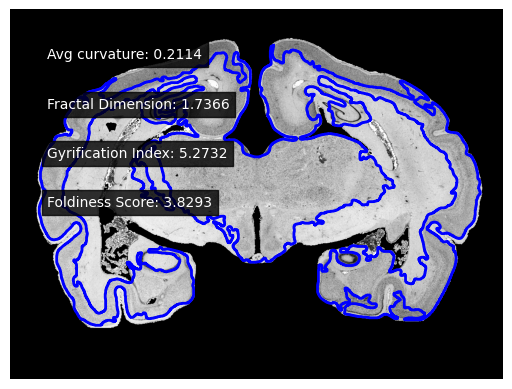

In [2]:
_=get_foldiness('./data/kangaroo_brain.jpg')


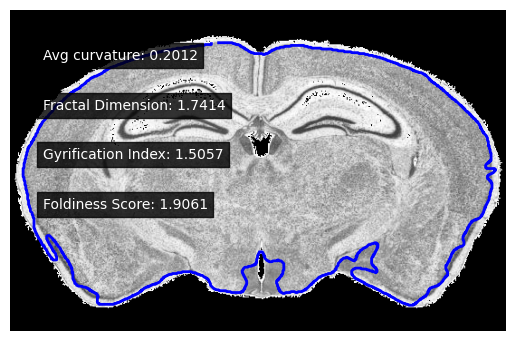

In [3]:
_=get_foldiness('./data/rat_brain.jpg')

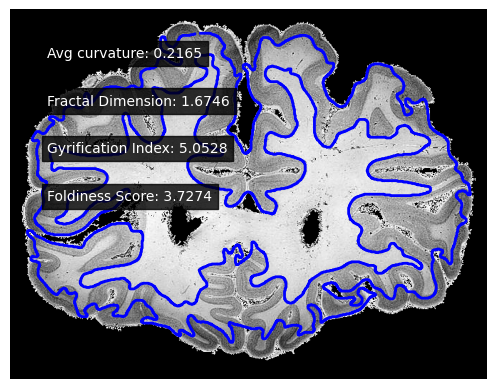

In [4]:
_=get_foldiness('./data/humanforebrain1.jpg')

## Use machine learning to classify the cortex
1. Hand label the gortex gray matter
2. Convert the image data to [n_samples,distance_from_center,grayscale_intensity]
3. Train a logistic regression model for classifying gray matter
4. Run Inference on the different types of brains

In [5]:
img = read_image('./data/kangaroo_brain.jpg').convert('L')

In [6]:
# freehand draw the rois for image labels
# mask = draw_freehand_roi('./data/kangaroo_brain.jpg', save_mask_path="./data/new_cortex_mask.png")

In [7]:
np_img = np.array(img)
bm = extract_largest_blob(np_img<250)
np_img = np_img
np_img.shape
np_img = (np_img - np.mean(np_img)) / np.std(np_img)


In [8]:
data = grayscale_to_distance_intensity_array(np_img)
data = np.reshape(data,[np_img.shape[0],np_img.shape[1],2])

(np.float64(-0.5), np.float64(1187.5), np.float64(890.5), np.float64(-0.5))

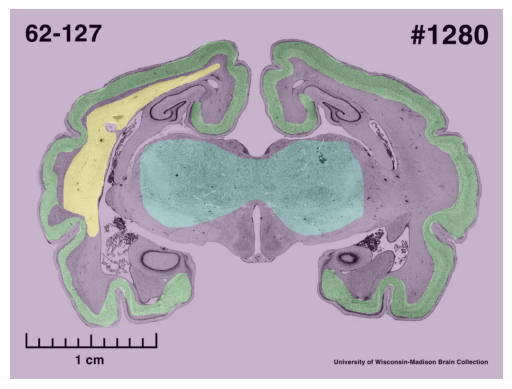

In [9]:
# visualize the labels
cm_mask=(np.array(read_image('./data/cortex_mask_center.png').convert('L'))>0)*2
gm_mask=(np.array(read_image('./data/cortex_mask_gm.png').convert('L'))>0 )*3
gm_mask+=(np.array(read_image('./data/cortex_mask_gm2.png').convert('L'))>0 )*3
wm_mask=(np.array(read_image('./data/cortex_mask_wm.png').convert('L'))>0 )*4
labels =cm_mask+gm_mask+wm_mask
plt.imshow(np_img,cmap='gray')
plt.imshow(labels,alpha=.3)
plt.axis('off')

In [10]:
labelled_data = label_and_stack(data, gm_mask, wm_mask, cm_mask)

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")


# Split features and labels
X = labelled_data[:, :2]  # features: first two columns
y = labelled_data[:, 2]   # labels: third column

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the classifier
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Validation Accuracy: {accuracy:.2f}")


Validation Accuracy: 0.90


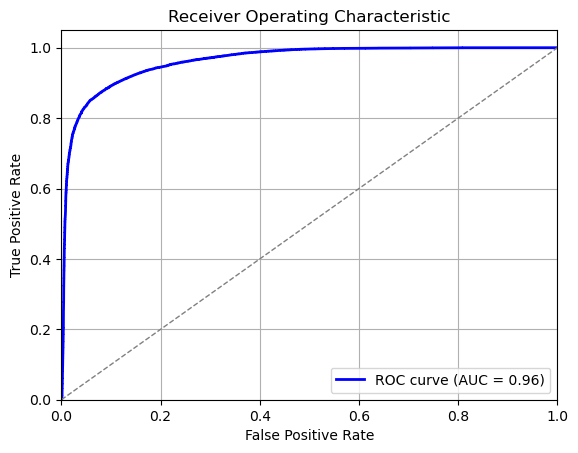

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_scores = clf.predict_proba(X_val)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Predicted Cortex GM')

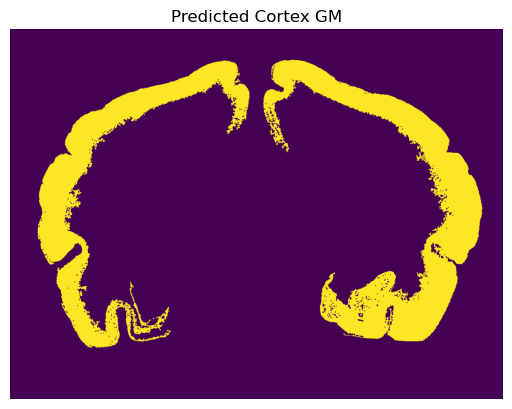

In [13]:
#visualize the predictions
preds = clf.predict(np.reshape(data,[(data.shape[0]*data.shape[1]),2]))
p = np.reshape(preds,[data.shape[0],data.shape[1]])
plt.imshow(p>0)
pp = morph_open_close(p==1, kernel_size=2, iterations=1)
pp = keep_large_components(pp, min_size=np.prod(np.shape(img))*.01)
pp = pp*bm
plt.imshow(pp)
plt.axis('off')
plt.title('Predicted Cortex GM')

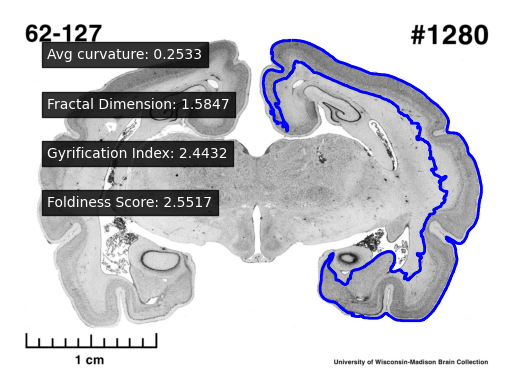

(np.float64(0.25328337605033235),
 np.float64(1.584710003135333),
 2.44324251883658,
 np.float64(2.551696764246686))

In [14]:
get_foldiness_from_mask('./data/kangaroo_brain.jpg',pp)

Text(0.5, 1.0, 'Predicted Cortex GM')

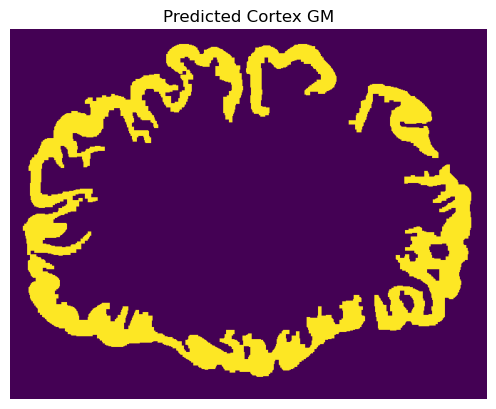

In [15]:
# Upload new image. Tweak params to adjust for new image and vizualize the labels before running the foldiness calculation
img = read_image('./data/humanforebrain1.jpg').convert('L')
np_img = np.array(img)
np_img = np_img
np_img.shape
np_img = (np_img - np.mean(np_img)) / np.std(np_img)
data = grayscale_to_distance_intensity_array(np_img)
data = np.reshape(data,[np_img.shape[0],np_img.shape[1],2])
preds = clf.predict(np.reshape(data,[(data.shape[0]*data.shape[1]),2]))
p = np.reshape(preds,[data.shape[0],data.shape[1]])
plt.imshow(p==1)
#adjust kernel size and iterations
pp = morph_open_close(p==1, kernel_size=5, iterations=1)
#adjust percentage of the image pixels to keep components
pp = keep_large_components(pp, min_size=np.prod(np.shape(img))*.01)
plt.imshow(pp)
plt.axis('off')
plt.title('Predicted Cortex GM')

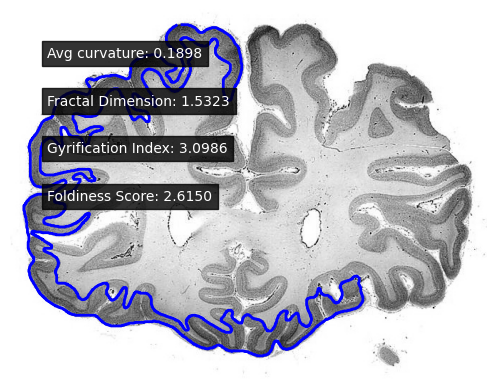

(np.float64(0.18981070647311366),
 np.float64(1.5323313721204188),
 3.09858358896944,
 np.float64(2.615000894801258))

In [16]:
get_foldiness_from_mask('./data/humanforebrain1.jpg',pp)

Text(0.5, 1.0, 'Predicted Cortex GM')

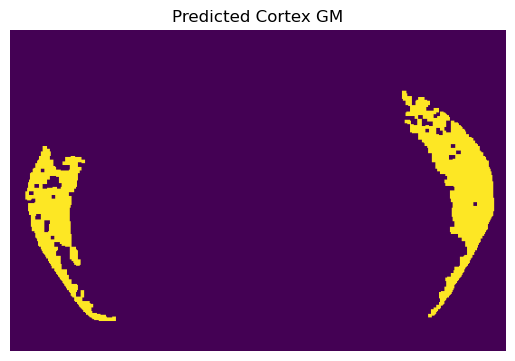

In [17]:
img = read_image('./data/rat_brain.jpg').convert('L')
np_img = np.array(img)
np_img = np_img
np_img.shape
np_img = (np_img - np.mean(np_img)) / np.std(np_img)
data = grayscale_to_distance_intensity_array(np_img)
data = np.reshape(data,[np_img.shape[0],np_img.shape[1],2])
preds = clf.predict(np.reshape(data,[(data.shape[0]*data.shape[1]),2]))
p = np.reshape(preds,[data.shape[0],data.shape[1]])
plt.imshow(p==1)
pp = morph_open_close(p==1, kernel_size=4, iterations=1)
pp = keep_large_components(pp, min_size=np.prod(np.shape(img))*.01)
plt.imshow(pp)
plt.axis('off')
plt.title('Predicted Cortex GM')

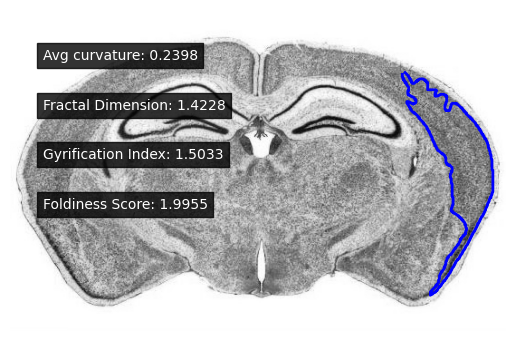

(np.float64(0.23981529167126608),
 np.float64(1.4228213467818693),
 1.5033484500019771,
 np.float64(1.995499661042427))

In [18]:
get_foldiness_from_mask('./data/rat_brain.jpg',pp)